<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span><ul class="toc-item"><li><span><a href="#Заказчик" data-toc-modified-id="Заказчик-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Заказчик</a></span></li><li><span><a href="#Задача" data-toc-modified-id="Задача-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Задача</a></span></li><li><span><a href="#Входные-данные" data-toc-modified-id="Входные-данные-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Входные данные</a></span><ul class="toc-item"><li><span><a href="#Термины" data-toc-modified-id="Термины-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Термины</a></span></li><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Описание данных</a></span><ul class="toc-item"><li><span><a href="#Посещения-(visits)" data-toc-modified-id="Посещения-(visits)-1.3.2.1"><span class="toc-item-num">1.3.2.1&nbsp;&nbsp;</span>Посещения (visits)</a></span></li><li><span><a href="#Покупки-(orders)" data-toc-modified-id="Покупки-(orders)-1.3.2.2"><span class="toc-item-num">1.3.2.2&nbsp;&nbsp;</span>Покупки (orders)</a></span></li><li><span><a href="#Расходы-на-рекламу-(costs)" data-toc-modified-id="Расходы-на-рекламу-(costs)-1.3.2.3"><span class="toc-item-num">1.3.2.3&nbsp;&nbsp;</span>Расходы на рекламу (costs)</a></span></li></ul></li></ul></li><li><span><a href="#План-работы" data-toc-modified-id="План-работы-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>План работы</a></span></li><li><span><a href="#Инструменты" data-toc-modified-id="Инструменты-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Инструменты</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Определения-констант" data-toc-modified-id="Определения-констант-1.5.2"><span class="toc-item-num">1.5.2&nbsp;&nbsp;</span>Определения констант</a></span></li><li><span><a href="#Определения-функций" data-toc-modified-id="Определения-функций-1.5.3"><span class="toc-item-num">1.5.3&nbsp;&nbsp;</span>Определения функций</a></span><ul class="toc-item"><li><span><a href="#Загрузка-и-обзор-данных" data-toc-modified-id="Загрузка-и-обзор-данных-1.5.3.1"><span class="toc-item-num">1.5.3.1&nbsp;&nbsp;</span>Загрузка и обзор данных</a></span></li><li><span><a href="#Исправление-данных" data-toc-modified-id="Исправление-данных-1.5.3.2"><span class="toc-item-num">1.5.3.2&nbsp;&nbsp;</span>Исправление данных</a></span></li><li><span><a href="#Преобразование-данных" data-toc-modified-id="Преобразование-данных-1.5.3.3"><span class="toc-item-num">1.5.3.3&nbsp;&nbsp;</span>Преобразование данных</a></span></li><li><span><a href="#Отображение-данных" data-toc-modified-id="Отображение-данных-1.5.3.4"><span class="toc-item-num">1.5.3.4&nbsp;&nbsp;</span>Отображение данных</a></span></li><li><span><a href="#Анализ-бизнеса" data-toc-modified-id="Анализ-бизнеса-1.5.3.5"><span class="toc-item-num">1.5.3.5&nbsp;&nbsp;</span>Анализ бизнеса</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Обзор-и-исправление-данных" data-toc-modified-id="Обзор-и-исправление-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обзор и исправление данных</a></span><ul class="toc-item"><li><span><a href="#Посещения-visits" data-toc-modified-id="Посещения-visits-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Посещения <code>visits</code></a></span></li><li><span><a href="#Заказы-orders" data-toc-modified-id="Заказы-orders-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Заказы <code>orders</code></a></span></li><li><span><a href="#Расходы-на-рекламу-costs" data-toc-modified-id="Расходы-на-рекламу-costs-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Расходы на рекламу <code>costs</code></a></span></li><li><span><a href="#Итоги-обзора-и-исправления-данных" data-toc-modified-id="Итоги-обзора-и-исправления-данных-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Итоги обзора и исправления данных</a></span></li></ul></li><li><span><a href="#Анализ-обобщённых-данных" data-toc-modified-id="Анализ-обобщённых-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обобщённых данных</a></span><ul class="toc-item"><li><span><a href="#Профили-profiles" data-toc-modified-id="Профили-profiles-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Профили <code>profiles</code></a></span></li><li><span><a href="#Начало-привлечения-min_acq_date" data-toc-modified-id="Начало-привлечения-min_acq_date-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Начало привлечения <code>min_acq_date</code></a></span></li><li><span><a href="#Окончание-привлечения-max_acq_date" data-toc-modified-id="Окончание-привлечения-max_acq_date-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Окончание привлечения <code>max_acq_date</code></a></span></li><li><span><a href="#Позователи-и-плательщики-по-странам,-устройствам-и-источникам" data-toc-modified-id="Позователи-и-плательщики-по-странам,-устройствам-и-источникам-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Позователи и плательщики по странам, устройствам и источникам</a></span></li><li><span><a href="#Итоги-оценки-обобщённых-данных" data-toc-modified-id="Итоги-оценки-обобщённых-данных-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Итоги оценки обобщённых данных</a></span></li></ul></li><li><span><a href="#Оценка-расходов-на-рекламу" data-toc-modified-id="Оценка-расходов-на-рекламу-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Оценка расходов на рекламу</a></span><ul class="toc-item"><li><span><a href="#Расходы-на-рекламу-(всего,-по-источникам-и-по-истории)" data-toc-modified-id="Расходы-на-рекламу-(всего,-по-источникам-и-по-истории)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Расходы на рекламу (всего, по источникам и по истории)</a></span><ul class="toc-item"><li><span><a href="#Всего" data-toc-modified-id="Всего-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Всего</a></span></li><li><span><a href="#По-источникам" data-toc-modified-id="По-источникам-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>По источникам</a></span></li><li><span><a href="#В-истории" data-toc-modified-id="В-истории-4.1.3"><span class="toc-item-num">4.1.3&nbsp;&nbsp;</span>В истории</a></span></li></ul></li><li><span><a href="#Cредний-CAC-на-пользователя-(всего,-и-по-источникам)" data-toc-modified-id="Cредний-CAC-на-пользователя-(всего,-и-по-источникам)-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Cредний CAC на пользователя (всего, и по источникам)</a></span></li><li><span><a href="#Итоги-оценки-расходов-на-рекламу" data-toc-modified-id="Итоги-оценки-расходов-на-рекламу-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Итоги оценки расходов на рекламу</a></span></li></ul></li><li><span><a href="#Оценка-окупаемости-пользователей" data-toc-modified-id="Оценка-окупаемости-пользователей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Оценка окупаемости пользователей</a></span><ul class="toc-item"><li><span><a href="#Итоги-оценки-окупаемости-пользователей" data-toc-modified-id="Итоги-оценки-окупаемости-пользователей-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Итоги оценки окупаемости пользователей</a></span></li></ul></li><li><span><a href="#Общие-итоги" data-toc-modified-id="Общие-итоги-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общие итоги</a></span><ul class="toc-item"><li><span><a href="#Рекомендации" data-toc-modified-id="Рекомендации-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Рекомендации</a></span></li></ul></li></ul></div>

# Название проекта

Учебный проект по специальности "аналитик данных".
Тема: анализ бизнес-показателей.

Автор: Александр Лагутин.

Начат: 21 августа 2022 г в 19:00.
Завершён: 22 августа 2022 г в 21:00.

Время подготовки: 12 рабочих часов (2 рабочих дня).

## Описание проекта

### Заказчик

Команда развлекательного приложения Procrastinate Pro+.

Основная деятельность: распространение ПО.

### Задача

Компания много вкладывает в рекламу. Надо найти причину убытков, возникших в последние несколько месяцев.

Для чего: чтобы рекламная компания окупала себя.

### Входные данные

Данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- расходы на рекламу.

#### Термины

Специальные термины не упомянуты.

#### Описание данных

##### Посещения (visits)

- `User Id` — идентификатор пользователя;
- `Region` — страна;
- `Device` — тип устройства;
- `Channel` — источник;
- `Session Start` — момент начала сессии;
- `Session End` — момент конца сессии.

##### Покупки (orders)

- `User Id` — идентификатор пользователя;
- `Event Dt` - момент покупки;
- `Revenue` - сумма покупки.

##### Расходы на рекламу (costs)

- `Channel` - источник;
- `Dt` - дата рекламы;
- `Revenue` - сумма расходов.

### План работы

Найти ответы на вопросы:
- откуда приходят пользователи;
- какими устройствами они пользуются;
- сколько стоит привлечение пользователей из разных рекламных каналов;
- сколько денег приносит каждый клиент;
- когда расходы на привлечение клиента окупаются;
- что мешает привлечению клиентов.

Действия:
- [x] Импортировать библиотеки, описать функции, которые потребуются для расчёта и диаграмм LTV, ROI, RR и CR.
- [x] Загрузить и изучить таблицы.
- [x] Подготовить данные:
  - [x] привести к норме названия столбцов;
  - [x] привести данные к нужным типам;
  - [x] обработать пропуски:
    - [x] выбрать, чем заполнить (или оставить) и почему;
    - [x] осуществить заполение, если требуется;
    - [x] описать причины, которые могли привести к пропускам.
- [x] Анализировать обобщённые данные:
  - [x] Создать профили пользователей.
    - [x] Найти минимальную и даты привлечения пользователей.
  - [x] Построить таблицы "Количество пользователей" - "Доля плативших", сгруппированные по странам, устройствам и источникам.
  - [x] Описать выводы.
- [ ] Оценить расходы на рекламу.
  - [ ] Сосчитать сумму расходов на маркетинг. Построить диаграммы, как расходы распределены по источникам и по истории.
  - [ ] Рассчитать средний CAC на пользователя:
    - [ ] Для всего проекта,
    - [ ] Для каждого источника.
  - [ ] Выводы
- [ ] Оценить окупаемость рекламы на 1.11.2019 на горизонте не позднее 2-ч недель после привлечения.
  - [ ] Окупаемость рекламы в целом. Построить графики LTV и ROI, а также динамика LTV, CAC и ROI.
  - [ ] Окупаемость по странам, устройствам и каналам. Построить аналогичные графики.
  - [ ] Описать выводы.
  - [ ] Графики конверсии и удержания по устройствам, странам и источникам.
    - [ ] Окупается ли реклама?
    - [ ] Какие устройства, страны, каналы хуже всего показываают?
    - [ ] В чём причины?
    - [ ] Что рекомендуете рекламному отделу сделать?
- [ ] Описать общий вывод:
  - [ ] причины неэффективности;
  - [ ] рекомендации отделу маркетинга.

### Инструменты

Используем [Anaconda](https://www.anaconda.com/), окружение `ds_da_practicum_env.yml` "для Mac OS" (от 2022-03-23).

#### Импорт библиотек

In [1]:
%matplotlib inline

import datetime
import re

import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

#### Определения констант

In [2]:
FIGSIZE = (12, 6)

#### Определения функций

##### Загрузка и обзор данных

In [3]:
def load(tablename, ext='csv'):
    """Load a table from file
    """
    filename = tablename + '.' + ext
    try:
        df = pd.read_csv(filename)
    except FileNotFoundError:
        df = pd.read_csv('https://code.s3.yandex.net/datasets/' + filename)
    correct_column_names(df)  #  переводит в snake_case
    survey(df)  # даёт обзор возможных проблем с таблицей
    return df

In [4]:
def survey(data):
    """Display summaries to detect data problems
    """
    display(data.sample(5))
    print(f'Полностью совпадающих строк: {data.duplicated().sum()}\n')
    data.info()
    display(get_nans(data))
    print(get_filled_rows_share(data))

In [5]:
def get_nans(data):
    nans = []
    for column in data.columns:
        missing = data[column].isna().sum()  # Подсчет количества отсутствующих значений
        part = round(missing * 100 / len(data), 2) # Подсчет доли отсутствующих значений
        uniques = data[column].sort_values().nunique()
        nans.append([column, missing, part, uniques])

    return pd.DataFrame(
        data=nans, columns=['column', 'na_count', 'na_%', 'unique_count']
    ).sort_values(['na_count', 'unique_count'], ascending=False).set_index('column')

In [6]:
def get_filled_rows_share(df):
    share = 1 - df.isna().any(axis=1).sum() / len(df)
    return f'Заполненных строк без пропусков: {share:.02%}'

##### Исправление данных

In [7]:
def correct_column_names(df):
    df.columns = df.columns.str.strip()
    df.columns = df.columns.str.replace(' ', '_')
    df.columns = df.columns.map(to_snake_case)

def to_snake_case(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    name = re.sub('__([A-Z])', r'_\1', name)
    name = re.sub('([a-z0-9])([A-Z])', r'\1_\2', name)
    return name.lower()

In [8]:
def fillnaby(data, column, groupby, func='median'):
    data[column] = data[column].fillna(
        data.groupby(groupby)[column].transform(func))

##### Преобразование данных

###### Moving Average: `add_ma`, `insert_ma`

In [9]:
def add_ma(df, window):
    """Return dataframe with added MA columns for each column
    """
    for column in df.columns.values:
        df[column + '_ma_' + str(window)] = df[column].rolling(window).mean() 
    return df 

In [10]:
def insert_ma(df, window):
    """Return dataframe with inserted MA for each column
    """
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

##### Отображение данных

In [11]:
def headline(line, width=50):
    """Возвращает заголовок, набранный "простым текстом".
    """
    return f'\n{line.upper():=^{width}}'

In [12]:
# можно было бы рисовать `bar` в случаях, когда вариантов мало.
# однако по неясной причине `bar` не рисуется, и не вызывает ошибки,
# а вызывает лишь зацикливание при построении первого же графика

def survey_columns(df):
    for column in nans_before.index:
        print(headline(column))

        uniques = realty[column].sort_values().unique()
        if len(uniques) < 20:
            print(uniques)
        print(f'Data type: {str(realty[column].dtype):>10}')
        print(f'Unique values: {len(uniques):6}')

        missing = realty[column].isna().sum()
        if missing:
            print(f'Not avaliable: {nans_before.loc[column, "na_part"]:.02%}')
        else:
            print('All values is avaliable.')

        try:
            realty.plot(
                kind='hist',
                y=column,
               bins=50,
            )
            plt.show()
        except Exception as e:
            print(str(e).capitalize())

In [13]:
# формирует и выводит график, подстроенный под наши нужды
def histf(data, column, show=True, bins=100, qtl=1, start=None,
          stop=None, figsize=FIGSIZE, **kwargs):
    fixed = {
        'y': column,
        'kind': 'hist',
        'bins': min(bins, len(data[column].unique())),
        'figsize': figsize,
        'title': column,
        'legend': False,
        'ec': 'black',
    }
    if 'range' not in kwargs.keys():
        if not start:
            start = data[column].min()
        if not stop:
            stop = data[column].quantile(qtl)
        kwargs['range'] = (start, stop)
    data.plot(**fixed, **kwargs)
    if show:
        plt.show()

def histf2(data, column1, column2, **kwargs):
    histf(column1, data=data, show=False, **kwargs)
    histf(column2, data=data, show=False, **kwargs)
    plt.show()

# два графика: все случаи, и те, что менее указанного квантиля
def dhistf(column, data, qtl=0.975, figsize=FIGSIZE, **kwargs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('This is a somewhat long figure title', fontsize=16)
    
    ax1.set_title('full_data')
    ax2.set_title(f'{qtl:.2%} quantile')
    histf(column, data=data, ax=ax1, subplots=True, show=False, **kwargs)
    histf(column, data=data, ax=ax2, subplots=True, show=False, qtl=qtl, **kwargs)
    plt.show()
# Развитая форма этого чудовища должна принимать список квантилей,
# и строить столько графиков, сколько квантилей указано,
# и качестве центра диапазона выбирать медиану.
# Пора перейти к аналитике.

In [14]:
def typical(data, column, ratio=1.5):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    whiskers = iqr * ratio
    low = q1 - whiskers
    high = q3 + whiskers
    
    print(f'{column.title()}: min = {data[column].min()},'
          f' max = {data[column].max()},'
          f' normal range = [{low:.2f} ... {high:.2f}]')

    return data.query(f'@low <= {column} <= @high')

In [15]:
quantitative_properties = [
]

categorical_properties = [
]

key_column = ''

def batch_corr(data, column=key_column):
    print(headline('Коэффициенты линейной корреляции'))
    display(
            data
            .reindex(columns=(quantitative_properties + categorical_properties))
            .corr()
            [column].sort_values(ascending=False)
    )

def batch_scatter(data, column=key_column):
    for prop in quantitative_properties:
        if prop == column:
            continue
        data.plot(
            kind='scatter', alpha=0.2, figsize=FIGSIZE,
            y=column,
            x=prop,
        )
    plt.show()

def batch_box(data, column=key_column, by_props=categorical_properties):
    for prop in by_props:
        data.boxplot(
            column=column,
            by=prop,
            figsize=FIGSIZE,
        )
    plt.show()

##### Анализ бизнеса

###### Профили: `get_profiles`

In [16]:
def get_profiles(sessions, orders, ad_costs):
    """Return user action profiles
    """

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles 

###### Удержание: `get_retention`, `plot_retention`

In [17]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    """Return retention rates
    """

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [18]:
def plot_retention(retention, retention_history, horizon, window=7):
    """Plot retention and RR history
    """

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

###### Конверсия `get_conversion`, `plot_conversion`

In [19]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    """Return conversion rates
    """

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [20]:
def plot_conversion(conversion, conversion_history, horizon, window=7):
    """Plot conversion and CR history
    """

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

###### Окупаемость `get_ltv`, `plot_ltv`

In [21]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    """Return lifetime value and return of investments
    """

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [22]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):
    """Plot lifetime value of user, return of investments and its history
    """

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## Обзор и исправление данных

### Посещения `visits`

In [23]:
visits = load('visits_info_short')

,user_id,region,device,channel,session_start,session_end
24050,802366279247,United States,Mac,organic,2019-05-25 12:57:16,2019-05-25 13:04:23
131818,702379966841,United States,iPhone,FaceBoom,2019-09-02 11:17:36,2019-09-02 11:33:14
181767,555591243309,United States,Mac,MediaTornado,2019-10-10 17:06:48,2019-10-10 17:19:46
285582,508689997783,UK,iPhone,organic,2019-09-24 22:09:24,2019-09-24 22:16:03
262367,254406837657,France,Android,WahooNetBanner,2019-08-16 17:37:15,2019-08-16 17:40:19


Полностью совпадающих строк: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


,na_count,na_%,unique_count
column,,,
session_start,0,0.0,306813
session_end,0,0.0,306793
user_id,0,0.0,150008
channel,0,0.0,11
region,0,0.0,4
device,0,0.0,4


Заполненных строк без пропусков: 100.00%


Данные полны. Посещения идут из 11 источников. 4 региона и 4 типа устройств. Приводим даты и время к нужным типам.

In [24]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_start'])

visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


### Заказы `orders`

In [25]:
orders = load('orders_info_short')

,user_id,event_dt,revenue
35904,501433228142,2019-09-18 17:59:50,4.99
29275,981784070463,2019-06-10 20:38:14,4.99
37241,975710979943,2019-10-02 05:21:20,4.99
9922,246878221552,2019-07-29 11:39:12,4.99
22644,856419621025,2019-10-07 21:42:35,4.99


Полностью совпадающих строк: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


,na_count,na_%,unique_count
column,,,
event_dt,0,0.0,40163
user_id,0,0.0,8881
revenue,0,0.0,5


Заполненных строк без пропусков: 100.00%


Данные по заказам также полны. Моменты входа приводим к нужному типу.

In [26]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


### Расходы на рекламу `costs`

In [27]:
costs = load('costs_info_short')

,dt,channel,costs
429,2019-07-09,RocketSuperAds,7.735
180,2019-05-01,MediaTornado,6.240
57,2019-06-27,FaceBoom,227.700
1561,2019-08-30,WahooNetBanner,35.400
1147,2019-07-07,LeapBob,9.450


Полностью совпадающих строк: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


,na_count,na_%,unique_count
column,,,
costs,0,0.0,608
dt,0,0.0,180
channel,0,0.0,10


Заполненных строк без пропусков: 100.00%


Пропусков и повторов нет. Данные за 180 дней. Даты приводим к нужному типу.

In [28]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


### Итоги обзора и исправления данных

- Названия колонок приведены к норме автоматически.
- Нет пропусков и дубликатов.
- Дати и время приведены к соответсвующему типу.

## Анализ обобщённых данных

Прямо не указано, и по данным не ясно, когда началось привлечение клиентов. Это следовало бы запросить у заказчика.

Предполагаем, что эти данные включают в себя историю привлечения с самого начала. Считаем, что сервиса не было посещений ранее, чем те, которые описаны в таблице посещений. Считаем, что не было расходов на привлечение ранее, чем указано в таблице расходов.

Также не описаны подробности: какую платформу использует приложение для работы, размещено ли на ресурсе что-то помимо приложения, какие действия мы ожидаем от пользователей и какие они фактически совершают.

Предполагаем, что ресурс представлен одной страницей (единой для всех пользователей), на которой лишь один целевой шаг - "заказать", и объект, который может привлечь пользователей (товар), тоже только один - "доступ к приложению".

### Профили `profiles`

In [29]:
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [30]:
profiles['user_id'].count()

150008

In [31]:
visits['user_id'].nunique()

150008

Итого, за всё время статистики привлечено 150 008 пользователей.ф

In [32]:
profiles['payer'].mean() * 100

5.920350914617887

Из них 5,92% - делали заказы.

### Начало привлечения `min_acq_date`

In [33]:
min_ack_date = profiles['dt'].min()
min_ack_date.strftime('%Y-%m-%d')

'2019-05-01'

### Окончание привлечения `max_acq_date`

In [34]:
max_ack_date = profiles['dt'].max()
max_ack_date.strftime('%Y-%m-%d')

'2019-10-27'

### Позователи и плательщики по странам, устройствам и источникам


====================BY CHANNEL====================


,total_users,payer_part
channel,,
FaceBoom,29144,0.122049
AdNonSense,3880,0.113402
lambdaMediaAds,2149,0.104700
TipTop,19561,0.096007
RocketSuperAds,4448,0.079137
WahooNetBanner,8553,0.052964
YRabbit,4312,0.038265
MediaTornado,4364,0.035747
LeapBob,8553,0.030633


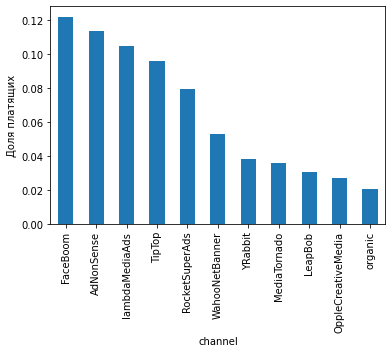


====================BY REGION=====================


,total_users,payer_part
region,,
United States,100002,0.069019
Germany,14981,0.041119
UK,17575,0.039829
France,17450,0.037994


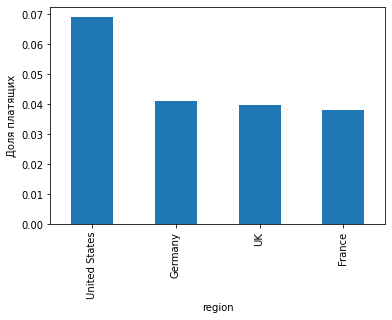


====================BY DEVICE=====================


,total_users,payer_part
device,,
Mac,30042,0.063644
iPhone,54479,0.062079
Android,35032,0.058518
PC,30455,0.050468


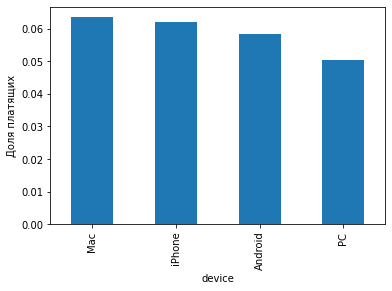

In [35]:
dimensions = ['channel', 'region', 'device']

for dim in dimensions:
    print(headline('by ' + dim))
    pivots = (
        profiles.groupby(dim)
        .agg({'user_id': 'nunique', 'payer': 'mean'})
        .rename(columns={'user_id': 'total_users', 'payer': 'payer_part'})
        .sort_values('payer_part', ascending=False)
    )
    display(pivots)
    pivots['payer_part'].plot(kind='bar')
    plt.ylabel('Доля платящих')
    plt.show()

### Итоги оценки обобщённых данных

- В данных описано привлечение пользователей с 1 мая по 27 октября 2019 года включительно.

- Самый качественный канал - FaceBoom: он привлёк больше, чем любой другой именованный канал, и доля плательщиков среди этих пользователей - наивысшая.

- Большая часть пользователей приходит из США. Доля плательщиков также выше среди пользователей из США. Остальные страны привлекают лишь треть пользователей, доля плательщиков среди них ниже, чем среди американцев.

- Среди пользователей разных устройств различия невелики. Доля плательщиков среди пользователей PC ниже, чем у других пользователей. Количество пользователей iPhone существенно выше, чем пользователей других платформ.

## Оценка расходов на рекламу

### Расходы на рекламу (всего, по источникам и по истории)

#### Всего

In [36]:
total_costs = costs['costs'].sum()
total_costs

105497.30000000002

#### По источникам

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


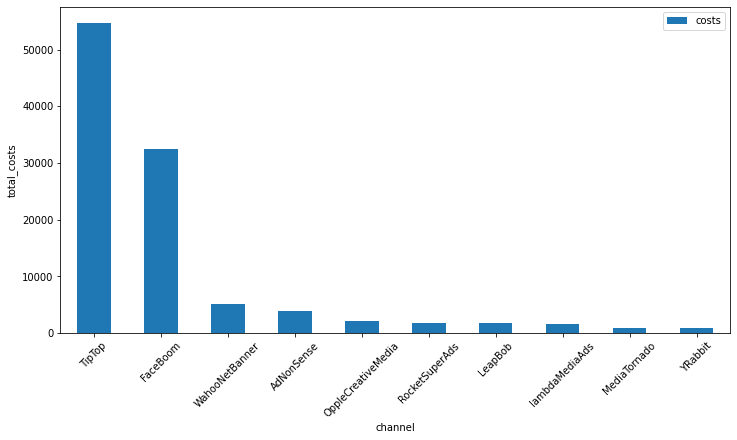

In [37]:
channel_costs = (
    costs.groupby('channel')
    .agg({'costs': 'sum'})
    .sort_values('costs', ascending=False)
)
display(channel_costs)

channel_costs.plot.bar(figsize=FIGSIZE,
                       ylabel='total_costs',
                       rot=45)
plt.show()

Видим, что основные расходы идут на TipTop и FaceBoom. Остальные источники получили мало вложений.

#### В истории

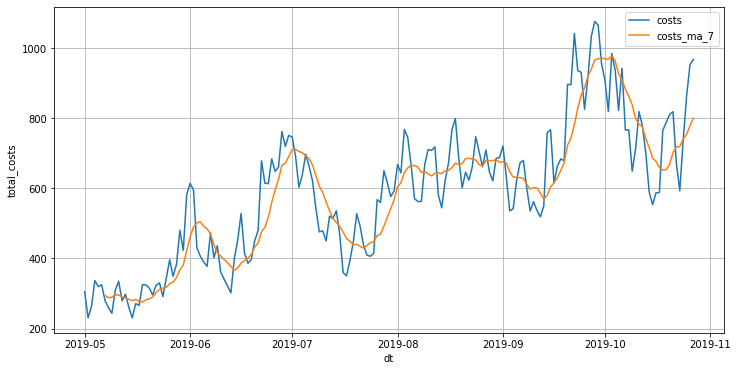

In [38]:
date_costs = (
    costs.groupby('dt')
    .agg({'costs': 'sum'})
)

add_ma(date_costs, 7).plot(figsize=FIGSIZE, grid=True, ylabel='total_costs')
plt.show()

Расходы со временем растут. Пики приходятся на стыки месяцев. Впадины - на середины.

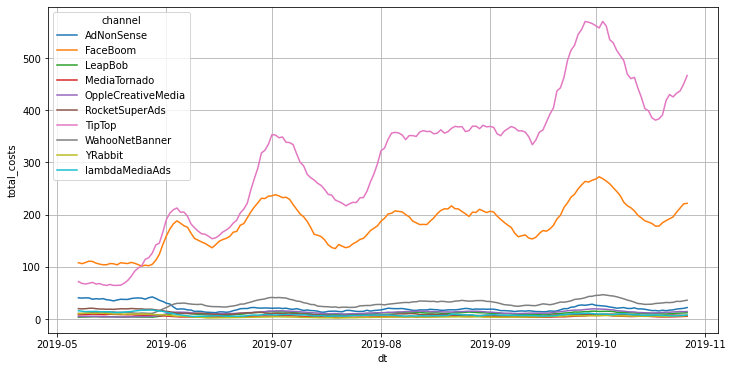

In [39]:
insert_ma(
    costs.pivot_table(
        index='dt', columns='channel', values='costs', aggfunc='sum'),
    7
).plot(figsize=FIGSIZE, grid=True, ylabel='total_costs')
plt.show()

Расходы на каждый из источнков повторяют ту периодичность, которую мы заметили. Нет заметных всплесков, отклонений. В целом расходы на TipTop заметно растут (каждый следующий пик сильно выше предыдущего). Расходы на остальные источники растут гораздо слабее.

### Cредний CAC на пользователя (всего, и по источникам)

In [40]:
costs['costs'].sum() / visits['user_id'].nunique()

0.703277825182657

Цена привлечения составила 0,7 за пользователя. Это средняя цена, учитывая и пользователей из бесплатных источников. Эта цена рассчитана из предположения, что все пользователи совершили первое посещение не ранее первого мая.

In [41]:
channel_users = (
    visits.sort_values('session_start')
    .groupby('user_id')
    .agg({'user_id': 'first', 'channel': 'first'})
    .groupby('channel')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'unique_users'})
)

channels = channel_costs.join(channel_users, how='outer').fillna(0)
channels['cac'] = channels['costs'] / channels['unique_users']
channels.sort_values('cac')

,costs,unique_users,cac
channel,,,
organic,0.00,56439,0.000000
LeapBob,1797.60,8553,0.210172
MediaTornado,954.48,4364,0.218717
YRabbit,944.22,4312,0.218975
OppleCreativeMedia,2151.25,8605,0.250000
RocketSuperAds,1833.00,4448,0.412095
WahooNetBanner,5151.00,8553,0.602245
lambdaMediaAds,1557.60,2149,0.724802
AdNonSense,3911.25,3880,1.008054


Органические пользователи 

### Итоги оценки расходов на рекламу

- Первый;
- Второй;
- Третий.

## Оценка окупаемости пользователей

### Итоги оценки окупаемости пользователей

- Первый;
- Второй;
- Третий.

## Общие итоги

- Исследовано:
  - выборка пяти сотен пользователей из разных регионов, подключившихся в 2018 году;
  - полная статистика их потребления звонков, коротких сообщений и интернет-трафика.
- **Подтверждённые выводы:**
  - Пользователь тарифа **"Ultra"** приносит **в среднем на 33% больше выручки**, чем пользователь тарифа "Smart".
  - **Средняя выручка** с пользователя **в Москве не отличается** от средней выручки с пользователя в других регионах.
- Также обнаружено, что:
  - Пользователей тарифа "Smart" в 4 раза больше;
  - Среди тех, кто потребляет много, популярней тариф "Ultra";
  - В среднем пользователи "Smart" потребляют столько, сколько включено в базовый пакет;
  - При относительно небольшом увеличении потребления их чек заметно вырастает;
  - Если потребление превышает 100 звонков (или 750 минут), или 110 сообщений, или 25 ГБ в месяц - пользователи предпочитают тариф "Ultra";
  - Пользователи "Ultra" потребляют только треть от базового пакета;
  - И 85% из них платят только базовый платёж.
- Предположения:
  - Пользователи "Smart":
    - сознательно ограничивают своё потребление;
    - при повышении потребления переходят на гораздо более содержательный "Ultra".
  - Пользователи "Ultra":
    - при повышении потребления вдвое не станут платить вдвое больше.

### Рекомендации

**Описание**

- пишем от лица "мы", употребляем подходящие времена
- Пиши краткие промежуточные выводы.
- Сделай общий вывод по итогам проекта в отдельном разделе.
- Сохрани идеи и код, который помогает принимать промежуточные решения.
- удали неработающий код
- комментарии ставь перед кодом
- вынеси комментарии в маркдаун
- подробно описывай процесс, что и почему ты делаешь
- за каждым пояснением - ячейка с кодом. Одна ячейка - один шаг
- перед отправкой - перезапусти вессь проект, убедись, что все ячейки сработали верно

**Вывод данных**
- Каждому объекту данных (фрейм, график) - дай название, подпись, подпиши столбцы и оси.
- Таблицы давай выборками, .head() и .tail()
- таблицы выводи по display()  # from IPython.display import display

**Итоги**
- краткий обзор проведённой работы: что выполнили, рассчитали:
- главные выводы: ответы на поставленные вопросы
- рекомендации: как избежать неправильных данных, как отобрать признаки для прогнозирования в будущем

На что обращают внимание при проверке проекта:
- [ ] Как вы описываете выявленные в данных проблемы?
- [ ] Как готовите датасет к анализу?
- [ ] Какие строите графики для распределений и как их объясняете?
- [ ] Как рассчитываете стандартное отклонение и дисперсию?
- [ ] Формулируете ли альтернативную и нулевую гипотезы?
- [ ] Какие методы применяете, чтобы их проверить?
- [ ] Объясняете результат проверки гипотезы или нет?
- [ ] Соблюдаете ли структуру проекта и поддерживаете аккуратность кода?
- [ ] Какие выводы делаете?
- [ ] Оставляете ли комментарии к шагам?